# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached tensorflow-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached tensorflow_gpu-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached opencv_python-4.5.3.56-cp37-cp37m-win_amd64.whl (34.9 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached numpy-1.19.5-cp37-cp37m-win_amd64.whl (13.2 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached wrapt-1.12.1-cp37-cp37m-win_amd64.whl
  Using cached protobuf-3.17.3-cp37-cp37m-win_amd64.whl (909 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462

## 1.2 Import Dependencies

In [8]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [6]:
!tar -xf lfw.tgz

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'lfw'

## 2.2 Collect Positive and Anchor Classes

In [5]:
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/0b766d1c-6708-11ed-9cf0-52e7e99dc11f.jpg'

In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    
    frame = frame[120:120+250,200:200+250, :]
    
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
       
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
   
    cv2.imshow('Image Collection', frame)
    
   
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        

cap.release()

cv2.destroyAllWindows()

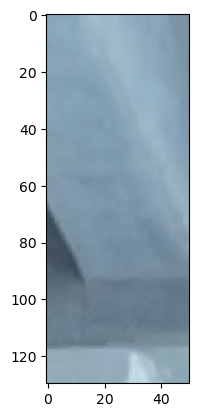

In [9]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data/anchor/97b00ee6-64ce-11ed-a4fb-52e7e99dc11f.jpg'


## 3.2 Preprocessing - Scale and Resize

In [14]:
def preprocess(file_path):
    
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    
    # Return image
    return img

In [15]:
img = preprocess('data/anchor/9768d774-64ce-11ed-a4fb-52e7e99dc11f.jpg')

In [16]:
img.numpy().max() 

0.989951

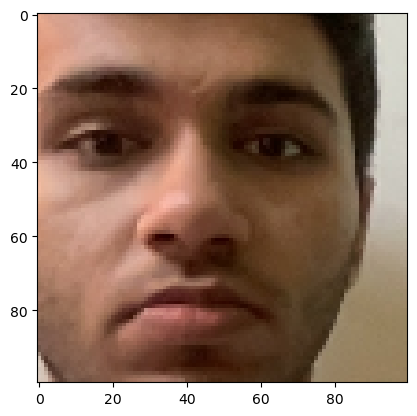

In [17]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [20]:
exampple = samples.next()

In [21]:
exampple

(b'data/anchor/b2bc4b28-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 b'data/positive/56702e2a-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*exampple)

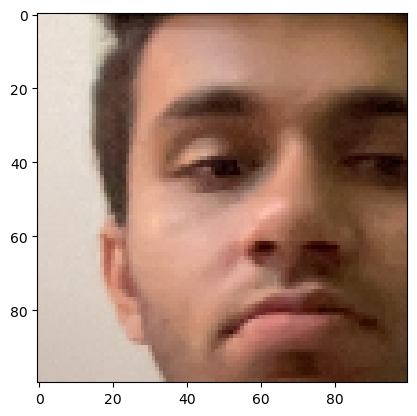

In [24]:
plt.imshow(res[1])

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [28]:
inp = Input(shape=(100,100,3), name='input_image')

In [29]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [30]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [31]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [32]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [33]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [34]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [36]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [37]:
embedding = make_embedding()

In [38]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [39]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
l1 = L1Dist()

In [41]:
l1

## 4.3 Make Siamese Model

In [42]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [43]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [44]:
siamese_layer = L1Dist()

In [45]:
distances = siamese_layer(inp_embedding, val_embedding)

In [46]:
classifier = Dense(1, activation='sigmoid')(distances)

In [47]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [50]:
def make_siamese_model(): 
    
   
    input_image = Input(name='input_img', shape=(100,100,3))
    
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
   
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_model = make_siamese_model()

In [52]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [53]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [54]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [56]:
test_batch = train_data.as_numpy_iterator()

In [58]:
batch_1 = test_batch.next()

In [59]:
X = batch_1[:2]

In [60]:
y = batch_1[2]

In [61]:
y

array([0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [62]:
tf.losses.BinaryCrossentropy??

In [63]:
@tf.function
def train_step(batch):
    
     
    with tf.GradientTape() as tape:     
       
        X = batch[:2]
        y = batch[2]
        
      
        yhat = siamese_model(X, training=True)
       
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
   
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
   
    return loss

## 5.4 Build Training Loop

In [64]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
       
        for idx, batch in enumerate(data):
          
            train_step(batch)
            progbar.update(idx+1)
        
       
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [66]:
EPOCHS = 50

In [67]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2022-11-15 15:49:58.173428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/27 [===========================>..] - ETA: 2sTensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2022-11-15 15:50:57.739042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 62s 2s/step

 Epoch 2/50
27/27 [==============================] - 62s 2s/step

 Epoch 3/50
27/27 [==============================] - 63s 2s/step

 Epoch 4/50
27/27 [==============================] - 63s 2s/step

 Epoch 5/50
27/27 [==============================] - 64s 2s/step

 Epoch 6/50
27/27 [==============================] - 68s 3s/step

 Epoch 7/50
27/27 [==============================] - 76s 3s/step

 Epoch 8/50
27/27 [==============================] - 85s 3s/step

 Epoch 9/50
27/27 [==============================] - 83s 3s/step

 Epoch 10/50
27/27 [==============================] - 85s 3s/step

 Epoch 11/50
27/27 [==============================] - 83s 3s/step

 Epoch 12/50
27/27 [==============================] - 85s 3s/step

 Epoch 13/50
27/27 [==============================] - 64s 2s/step

 Epoch 14/50
27/27 [==============================] - 80s 3s/step

 Epoch 15/50
27/27 [==============================] - 68s 3s/step

 Epoch 16/50
27/

# 6. Evaluate Model

## 6.1 Importing Metrics

In [65]:
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [66]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [68]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 23ms/step


array([[0.49715668],
       [0.49729067],
       [0.4960915 ],
       [0.49905825],
       [0.49783197],
       [0.49813214],
       [0.4948124 ],
       [0.498485  ],
       [0.49633485],
       [0.49864992],
       [0.49750212],
       [0.49179164],
       [0.49960586],
       [0.494288  ],
       [0.49852866],
       [0.49749798]], dtype=float32)

In [69]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [70]:
y_true

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [71]:
m = Recall()
 
m.update_state(y_true, y_hat)


m.result().numpy()

0.0

In [72]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

0.0

## 6.4 Viz Results

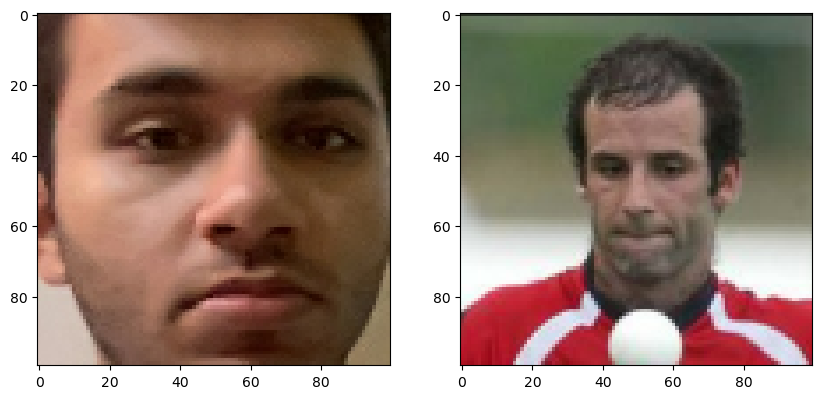

In [73]:
plt.figure(figsize=(10,8))


plt.subplot(1,2,1)
plt.imshow(test_input[3])


plt.subplot(1,2,2)
plt.imshow(test_val[2])


plt.show()

# 7. Save Model

In [74]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [75]:
L1Dist

__main__.L1Dist

In [76]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [77]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 115ms/step


2022-11-18 11:46:32.698575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.49715668],
       [0.49729067],
       [0.4960915 ],
       [0.49905825],
       [0.49783197],
       [0.49813214],
       [0.4948124 ],
       [0.498485  ],
       [0.49633485],
       [0.49864992],
       [0.49750212],
       [0.49179164],
       [0.49960586],
       [0.494288  ],
       [0.49852866],
       [0.49749798]], dtype=float32)

In [83]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function 

In [85]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0ca926e8-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0ed85592-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0b781dc4-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1b83eca2-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0d41aa9e-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '3a984a98-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '3b638bf4-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '.DS_Store',
 '5a2bbb24-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '3e2bed04-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '3d2d3ff2-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1a52f67a-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '4accb07a-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0e72dae6-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0fb2f7d8-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '3c2ef1b8-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0e0d0798-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0c438f18-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1c1c721a-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1bb6c348-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '0da75150-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1c4f4492-64ce-11ed-a4fb-52e7e99dc11f.jpg',
 '1ab895e8-64ce-11ed-a4fb-52e7e99dc11f.jp

In [86]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [87]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/0ca926e8-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/0ed85592-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/0b781dc4-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/1b83eca2-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/0d41aa9e-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/3a984a98-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/3b638bf4-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/.DS_Store
application_data/verification_images/5a2bbb24-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/3e2bed04-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/3d2d3ff2-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/1a52f67a-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/verification_images/4accb07a-64ce-11ed-a4fb-52e7e99dc11f.jpg
application_data/

In [88]:
def verify(model, detection_threshold, verification_threshold):
   
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
     
    detection = np.sum(np.array(results) > detection_threshold)
    
   
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [92]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
   
    if cv2.waitKey(10) & 0xFF == ord('v'):
       
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
      
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step
False
